In [1]:
from codes.construction_bases import *
from codes.fonctions_auxiliaires import *
from codes.classes import *
from codes.calculs import *
from codes.affichages import *

from codes.config import *
from codes.export import *

In [2]:
code_ad = 'LFBR'

conf = export(code_ad)

data = charge_fichier(conf.chemin_observations)
# metars = build_dict_metar('data/metar/'+code_ad+'.txt')

ad = aerodrome(code_ad)

In [3]:
def recup_qnh(data):
    '''
    Entrée : Liste des observations
    Sortie : liste des couples (QNH, date)
    '''
    res=[]
    for d in data:
        if (not ('qnh' in d.a_donnees_manquantes())) and (not (d.qnh == '')):
            res.append((d.qnh,d.date))
    return res

def recup_temp(data):
    '''
    Entrée : Liste des observations
    Sortie : liste des couples (temperature, date)
    '''
    res=[]
    for d in data:
        if (not ('temperature' in d.a_donnees_manquantes())) and (not (d.temperature == '')):
            res.append((d.temperature,d.date))
    return res

def recup_precip(data):
    '''
    Entrée : Liste des observations
    Sortie : liste des couples (precipitation, date)
    '''
    dico = precipitation_par_jour(data)
    res=[]
    for key in dico.keys():
        res.append((dico[key],key))
    return res

def enleve_doublon(liste):
    '''
    Entrée : Liste de couple
    Sortie : liste des couples sans doublon du deuxieme element (_,b) [b unique]
    '''
    res=[]
    double=[]
    for (a,b) in liste:
        if not(b in double):
            res.append((a,b))
            double.append(b)
    return res
        

def liste_occurences(data,fonction,seuil,operation):
    '''
    Entrée : Liste des observations, fonction d'extraction,seuil de comparaison, operation de comparaison
    Sortie : liste des couples (valeur, date) où la valeur est 'operation' au seuil 
    '''
    valeurs = fonction(data)
    res=[(val,datetime.datetime(date.year,date.month,date.day)) for (val,date) in valeurs if operation(val,seuil)]
    return enleve_doublon(res)

def inferieur_a(a,b):
    '''
    Entrée : a,b entiers ou floats
    Sortie : bool a<b
    '''
    return a<b    

def superieur_a(a,b):
    '''
    Entrée : a,b entiers ou floats
    Sortie : bool a>b
    '''
    return a>b 

In [4]:
occurences = liste_occurences(data,recup_qnh,985,inferieur_a)

In [5]:
def temps_entre_occurence(occurences,seuil=3):
    '''
    Entrée : liste des occurences [(valeur,date)...]
    Sortie : liste des temps entre deux occurences
    '''
    res=[]
    for k in range(len(occurences)-1):
        Δt =  occurences[k+1][1] - occurences[k][1]
        if Δt>datetime.timedelta(seuil):
            res.append(Δt.days)
    return res

In [6]:
temps_entre_occurence(liste_occurences(data,recup_qnh,990,inferieur_a))

[10, 253, 801, 386, 291, 64, 392, 652, 80, 336, 294, 27]

In [7]:
def duree_retour(data,fonction,seuil,operation):
    '''
    Entrée : Liste des observations, fonction d'extraction, seuil du phenomène, operation de comparaison
    Sortie : durée de retour en mois
    '''
    occurences = liste_occurences(data,fonction,seuil,operation)
    tps_entre = temps_entre_occurence(occurences)
    if tps_entre==[]:
        return None
    else:
        return round(moyenne(tps_entre)/31,1)
    

In [8]:
for qnh in range(980,990):
    print(qnh, duree_retour(data,recup_qnh,qnh, inferieur_a))

980 None
981 None
982 60.2
983 28.7
984 28.7
985 28.7
986 22.9
987 19.1
988 14.3
989 12.8


In [15]:
def trace_duree_retour_qnh(data,conf,borne_inf=875,borne_sup=1045):
    X = []
    Y = []
    for qnh in range(borne_inf,borne_sup+1):
        if qnh<=1013:
            dr = duree_retour(data,recup_qnh,qnh, inferieur_a)
        else:
            dr = duree_retour(data,recup_qnh,qnh, superieur_a)
        if dr != None:
            X.append(dr)
            Y.append(qnh)
    plt.scatter(Y, X)
    plt.xlabel('QNH (hPa)')
    plt.ylabel('Nombre de mois')
    plt.title('Durée de retour QNH')
    plt.savefig(
        'Figures_raw/'+conf.chemin_observations[-9:-5]+'/duree_retour_qnh.svg', format='svg')
    
    if config.SHOW:
        plt.show()
    plt.close('all')
    
def trace_duree_retour_temp(data,conf,borne_inf=-20,borne_sup=45):
    X = []
    Y = []
    for qnh in range(borne_inf,borne_sup+1):
        if qnh>15:
            dr = duree_retour(data,recup_temp,qnh, superieur_a)
        else:
            dr = duree_retour(data,recup_temp,qnh, inferieur_a)
        if dr != None:
            X.append(dr)
            Y.append(qnh)
    plt.scatter(Y, X)
    plt.xlabel('Température (°C)')
    plt.ylabel('Nombre de mois')
    plt.title('Durée de retour Température')
    plt.savefig(
        'Figures_raw/'+conf.chemin_observations[-9:-5]+'/duree_retour_temp.svg', format='svg')
    
    if config.SHOW:
        plt.show()
    plt.close('all')
    
def trace_duree_retour_precip(data,conf,borne_inf=0,borne_sup=60):
    X = []
    Y = []
    for qnh in range(borne_inf,borne_sup+1):
        dr = duree_retour(data,recup_precip,qnh, superieur_a)
        if dr != None:
            X.append(dr)
            Y.append(qnh)
    plt.scatter(Y, X)
    plt.xlabel('Precipitation (mm/jour)')
    plt.ylabel('Nombre de mois')
    plt.title('Durée de retour Precipitation')
    plt.savefig(
        'Figures_raw/'+conf.chemin_observations[-9:-5]+'/duree_retour_precip.svg', format='svg')
    
    if config.SHOW:
        plt.show()
    plt.close('all')

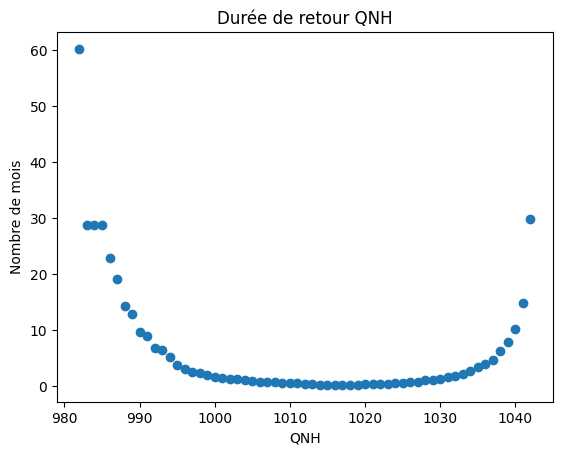

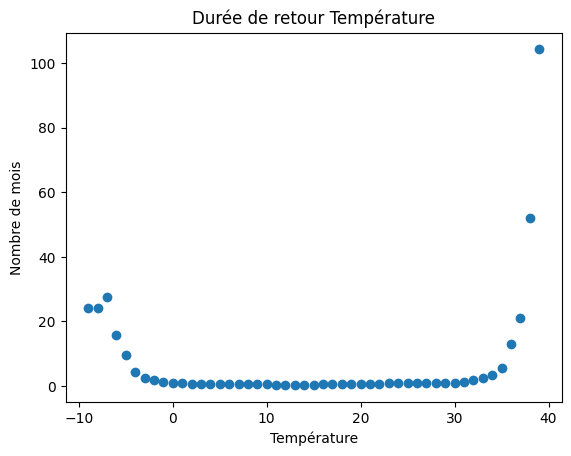

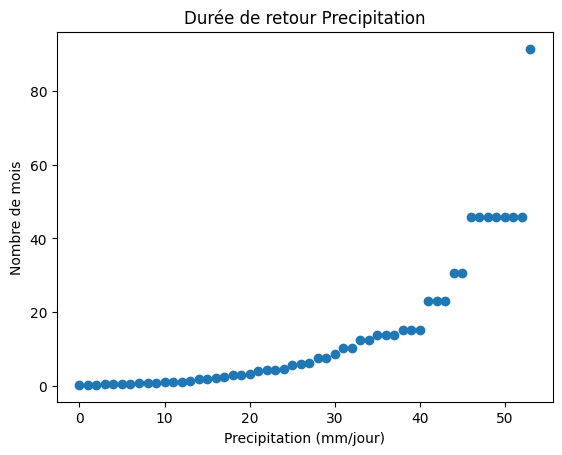

In [16]:
trace_duree_retour_qnh(data,conf)
trace_duree_retour_temp(data,conf)
trace_duree_retour_precip(data,conf)